In [35]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [37]:
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [38]:
test_id = test.ID
test = test.drop(["ID"],axis=1)

X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)
print(X_train.shape, X_test.shape, test.shape)

((60816, 306), (15204, 306), (75818, 306))


In [39]:
clf = ExtraTreesClassifier(random_state=1729)
selector = clf.fit(X_train, y_train)

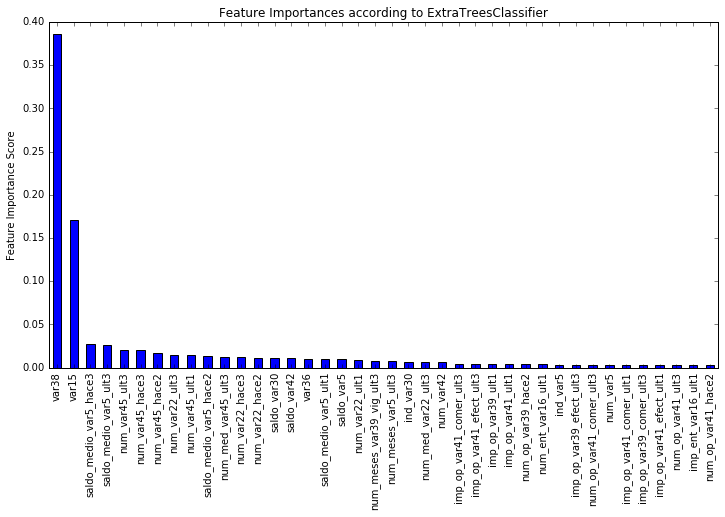

In [40]:
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('1.png')
plt.show()

In [41]:
# fs = SelectFromModel(selector, prefit=True)

# X_train = fs.transform(X_train)
# X_test = fs.transform(X_test)
# test = fs.transform(test)

print(X_train.shape, X_test.shape, test.shape)

((60816, 306), (15204, 306), (75818, 306))


In [42]:
m2_xgb = xgb.XGBClassifier(n_estimators=100, nthread=-1, max_depth = 5, seed=1729,
                           learning_rate=0.020205, subsample = 0.6815, colsample_bytree = 0.701)

m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])


print("Roc AUC: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1], average='macro'))

('Roc AUC: ', 0.82417977697323197)


In [33]:
probs = m2_xgb.predict_proba(test)

In [34]:
submission = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})
submission.to_csv("submission.csv", index=False)